# Libraries

In [2]:
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import math
from numpy import linalg

root = str(Path().resolve().parent)
if root not in sys.path:
    sys.path.append(root)
print(*sys.path, sep="\n")

# %matplotlib ipympl
%matplotlib inline

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


In [3]:
from importlib import reload
from rfdsppy import calc, ofdm, rf_analog, rf_tx_fw, tonegen, digital_filter_design, digital_hw_algo as dighw, rf_estimation as rf_est
from rfdsppy import rx_dfe_impcomp as rx_dfe

reload(calc)
reload(ofdm)
reload(rf_analog)
reload(rf_tx_fw)
reload(tonegen)
reload(digital_filter_design)
reload(dighw)
reload(rf_est)
reload(rx_dfe)

<module 'rfdsppy.rx_dfe_impcomp' from '/home/ryanwtsai/repos/rfdsp_sim/python/rfdsppy/rx_dfe_impcomp.py'>

# Separate the Rx contribution

In [7]:
rng = np.random.default_rng()

bw = 20
scs = 15
modorder = 64
start_sc = 0
num_sc = 1200

wg = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc)

ep_abs = 0.1
theta_abs = 5
ep0 = rng.uniform(low=-ep_abs, high=ep_abs)
theta0 = rng.uniform(low=-theta_abs*np.pi/180, high=theta_abs*np.pi/180)

ep1 = rng.uniform(low=-ep_abs, high=ep_abs)
theta1 = rng.uniform(low=-theta_abs*np.pi/180, high=theta_abs*np.pi/180)

iq_up = rf_analog.IQUpconverter(theta=theta0, ep=ep0)
iq_down = rf_analog.IQDownconverter(theta=theta1, ep=ep1)

alpha = 1
phase_shift = 20*np.pi/180
beta = alpha*np.exp(1j*phase_shift)

x, x_standard = wg.generate(14*3)
cfg = wg.get_demod_params()
fs = cfg.get("fs")
wola_len = cfg.get("wola_len")

# Alpha
tx = iq_up.transform(x)
tx = tx*alpha
y = iq_down.transform(tx)
X = np.hstack((x.reshape((x.size, 1)), x.conjugate().reshape((x.size, 1))))
X_pinv = linalg.pinv(X)
A = X_pinv @ y.reshape((y.size, 1))

# Beta
tx = iq_up.transform(x)
tx = tx*beta
y = iq_down.transform(tx)
# X = np.hstack((x.reshape((x.size, 1)), x.conjugate().reshape((x.size, 1))))
# X_pinv = linalg.pinv(X)
B = X_pinv @ y.reshape((y.size, 1))

A_rat = A[1]/A[0].conjugate()
B_rat = B[1]/B[0].conjugate()

c = (A_rat-np.exp(-2j*phase_shift)*B_rat)/(1-np.exp(-2j*phase_shift))
# print(c.real)
print(c)

gm = ep1/2*np.cos(theta1/2) + 1j*np.sin(theta1/2)
gd = np.cos(theta1/2) - 1j*ep1/2*np.sin(theta1/2)
coeff_img = -gm/gd
print(coeff_img)

[-0.01481862+0.03123003j]
(0.014673875960022805-0.03130083169603357j)


# Compensate Rx

EVM (Rx after comp): 0.046 %
SNR (Rx after comp): 66.76 dB


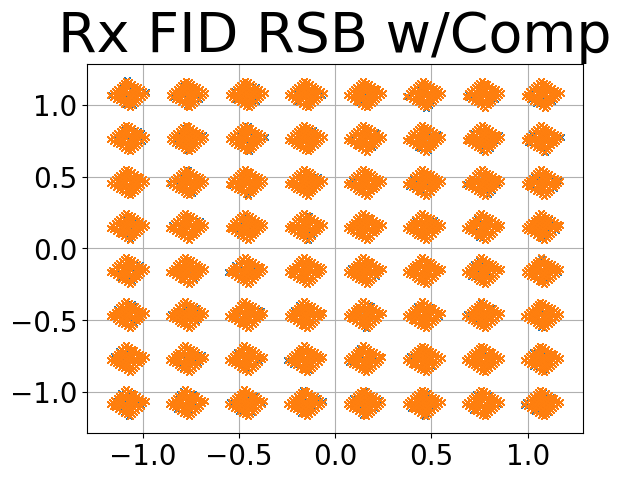

In [17]:
rx_iqmc = rx_dfe.IQMC(1, -c.item())
tx = iq_up.transform(x)
y = iq_down.transform(tx)
y_c = rx_iqmc.transform(y)
# y_c = y
evm = wg.calculate_evm(tx[round(wola_len/2):], y_c[round(wola_len/2):], en_plot=True, title="Rx FID RSB w/Comp")
print(f"EVM (Rx after comp): {round(evm,3)} %")
print(f"SNR (Rx after comp): {round(-20*np.log10(evm/100), 2)} dB")

In [41]:
w = X_pinv @ (y_c - x).reshape((x.size, 1))
w

array([[-0.00424027-0.00033391j],
       [ 0.0113999 -0.02920796j]])

In [42]:
w0 = np.array([1, 0]).reshape(w.shape) - w

In [43]:
w0

array([[ 1.00424027+0.00033391j],
       [-0.0113999 +0.02920796j]])

In [44]:
tx_iqmc = rx_dfe.IQMC(coeff_sig=w0[0], coeff_img=w0[1])

EVM (Tx+Rx after comp): 0.027 %
SNR (Tx+Rx after comp): 71.5 dB


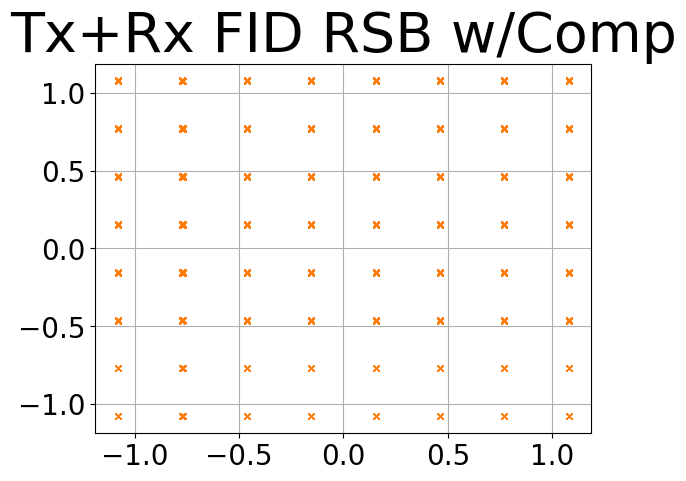

In [45]:
# x_c = x*w0[0] + x.conjugate()*w0[1]
x_c = tx_iqmc.transform(x)
# x_c = x
tx = iq_up.transform(x_c)
y = iq_down.transform(tx)
y_c = rx_iqmc.transform(y)

evm = wg.calculate_evm(x[round(wola_len/2):], y_c[round(wola_len/2):], en_plot=True, title="Tx+Rx FID RSB w/Comp")
print(f"EVM (Tx+Rx after comp): {round(evm,3)} %")
print(f"SNR (Tx+Rx after comp): {round(-20*np.log10(evm/100), 2)} dB")